# Part One: Network models


In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math
import random

## 1. Watts-Stogatz Networks


### 1.1) Use nx.watts_strogatz_graph to generate 3 graphs with 500 nodes each, average degree = 4, and rewiring probablity $p = 0, 0.1, \textrm{and} 1$. Calculate the average shortest path length $\langle d \rangle$ for each one. Describe what happens to the network when $p = 1$.

In [2]:
N = 500
k = 4
g_1 = nx.watts_strogatz_graph(n=N, k=k, p=1.0)
g_01 = nx.watts_strogatz_graph(n=N, k=k, p=0.1)
g_0 = nx.watts_strogatz_graph(n=N, k=k, p=0.0)

print "Average shortest path lengths for:"
print "p = 1.0: %s" % nx.average_shortest_path_length(g_1)
print "p = 0.1: %s" % nx.average_shortest_path_length(g_01)
print "p = 0.0: %s" % nx.average_shortest_path_length(g_0)

Average shortest path lengths for:
p = 1.0: 4.71827655311
p = 0.1: 7.83044488978
p = 0.0: 62.875751503


The WS model interpolates between a lattice (high clustering, no small world property) and a random network (low clustering, has small world property).  
For $p=0$: it's a lattice.  
For $p=1$: there is a 100% chance that each link will be rewired to a uniformly chosen other node, making it a random network.

For a random network, the average distance can be expressed as:  
$ \langle d \rangle \approx \frac{\ln N}{\ln \langle k \rangle} $

For the $p=1$ network, this comes very close to the empirical average distance (shortest path length) found above.

In [3]:
# average distance for a random network
# <d> = ln N / ln <k>
import math
math.log(500)/math.log(4)

4.4828921423310435

### 1.2) Let's understand the behavior of the WS model as we increase p in more detail.. Generate 50 networks with $N = 500$, $\langle k \rangle = 4$, for each of $p = \{0, 0.01, 0.03, 0.05, 0.1, 0.2\}$. Calculate the average of $\langle d \rangle$ as well as the standard deviation over the 50 networks, to create a plot that shows how the path length decreases very quickly with only a little fraction of re-wiring. Use the standard deviation to add errorbars to the plot.


In [ ]:
ps = [0.0, 0.01, 0.03, 0.05, 0.1, 0.2]
n_networks = 50
d_vals = np.zeros( (len(ps),n_networks) ) # init array to keep average distances for networks

for i, p in enumerate(ps):
  print "%s" % i
  for n_i in range(n_networks):
    g = nx.watts_strogatz_graph(n=500, k=4, p=p)
    d_vals[i,n_i] = nx.average_shortest_path_length(g)


<Container object of 3 artists>

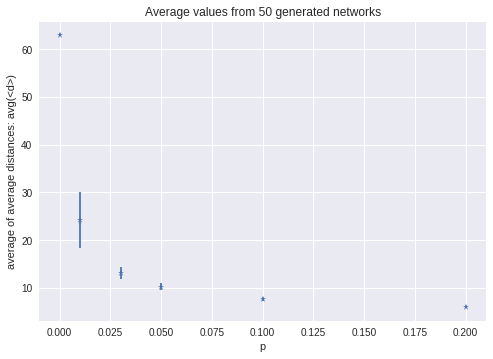

In [46]:
plt.title("Average values from {} generated networks".format(n_networks))
plt.xlabel("p")
plt.ylabel("average of average distances: avg(<d>)")
plt.errorbar(ps, np.mean(d_vals, axis=1), yerr=np.std(d_vals, axis=1), fmt="*")

## 2. The Barabási-Albert Model


In [ ]:
def dynamic_graph(N=10, with_pref_attach=True):
  """ Return: graph, node_degrees """
  
  # Every node occurs in this list, as many times as their degree.
  # Choosing uniformly from this, takes into account the node's degree
  node_degrees = [0,1]

  # start with 2 nodes and a link between them
  g = nx.Graph()
  id_counter = 1 # keep track of node ids
  g.add_edge(0,1)
  
  # 2 nodes already exist, so number of timesteps is N-2 to ensure a network of N nodes
  T = N-2

  for t in range(T):
    id_counter += 1 # add 1 for new node
    g.add_node(id_counter)
    
    # Preferential attachment: weighted likelihood of choosing node
    # No preferential attachment: randomly choose any node
    if with_pref_attach:
      chosen_node = random.choice(node_degrees)
    else:
      # range: [0-id_counter[, ensuring the new node isn't included
      chosen_node = random.choice( range(id_counter) )
    
    g.add_edge(id_counter, chosen_node)
    node_degrees.append(chosen_node)
    node_degrees.append(id_counter)
  return g, node_degrees

### Create a 100 node BA network using a BA model that you've coded on your own (so don't use the built-in NetworkX function, but the one you created during week 3). And plot it using NetworkX.

In [ ]:
g, _ = dynamic_graph(100)

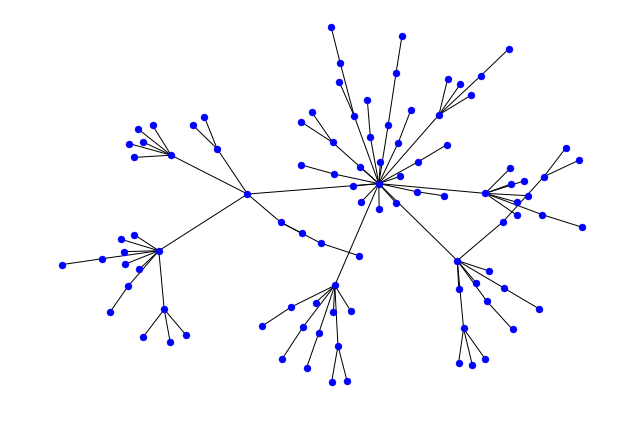

In [6]:
nx.draw(g, node_size=50, node_color="blue")

### Now create a 5000 node network.
What's the maximum and minimum degree?  
Now, bin the degree distribution, for example using numpy.histogram.  
Plot the distribution. Plot it with both linear and log-log axes.

In [ ]:
g, node_degrees = dynamic_graph(5000)

In [8]:
k_i = np.bincount(node_degrees) # k_i, node i's degree
# un-normalized p_k (aka degree distribution)
p_k = np.bincount(k_i) 

print "Degree count: min={0}, max={1}".format( min(k_i), max(k_i))

Degree count: min=1, max=133


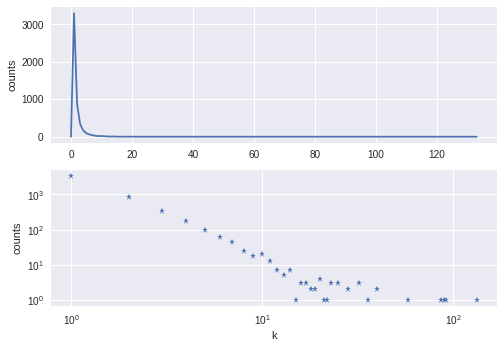

In [9]:
plt.subplot(2,1,1)
plt.ylabel("counts")
plt.plot( range(len(p_k)), p_k)

plt.subplot(2,1,2)
plt.ylabel("counts")
plt.xlabel("k")
plt.loglog(range(len(p_k)), p_k, "*")

Looking at the drawing of the 100 node graph and the degree distribution plots for the 5000 node graph above, it is clear that the custom BA model (dynamic_graph) works. The degree distribution follows a power-law and hubs are clearly visible.

## 3. Power-laws and the friendship paradox
Next step is to explore the Friendship paradox. This paradox states that almost everyone have fewer friends than their friends have, on average. This sounds crazy, but is actually an almost trivial consequence of living in a social network with a power-law degree distribution. The explanation is that almost everyone is friends with a hub, that drives up the average degree of the friends. Let's explore that in the 5000 node BA network we've just generated. Do the following:

### 3.1) 
Pick a node i at random (e.g. use random.choice). Find its degree.  
Find i's neighbors. And calculate their average degree.  
Compare the two numbers to check if it's true that i's friends (on average) have more friends than i.  

In [10]:
def avg_degree_neighbors(g):
  # pick random node
  rn = random.choice( range(g.size()) )

  # find random node's neighbors
  ns = list(g.neighbors(rn))

  # calc their average degree
  total_degrees = 0
  for n in ns:
    total_degrees += g.degree(n)
  avg_degree = total_degrees / float(len(ns))
  return ns, avg_degree

ns, avg_degree = avg_degree_neighbors(g)
  

print "Number of neighors: %s" % len(ns)
print "Average degree of neighbors: %s" % avg_degree

Number of neighors: 1
Average degree of neighbors: 10.0


### 3.2) Do this 1000 times. How many out of those 1000 times is the friendship paradox true?

In [11]:
# find average degree of neighbors a 1000 times
paradox_true = 0
for _ in range(1000):
  ns, avg_degree = avg_degree_neighbors(g)
  if len(ns) < avg_degree:
    paradox_true += 1
  
print "The paradox is true %d %% of the time" % (paradox_true / float(1000) * 100)

The paradox is true 86 % of the time


# Part Two: The network of American politics
This exercise assumes that you have already downloaded wiki-pages and created the directed network of members of congress from Wikipedia (see Week 4's exercises).


## 4. Basic stats for pages over time

### 4.0) download data

In [ ]:
import re
import requests
import pandas as pd
from StringIO import StringIO

In [62]:
# download data
url_folder = "https://raw.githubusercontent.com/suneman/socialgraphs2018/master/files/data_US_congress/"

h113_str = requests.get(url_folder + "H113.csv").content
h114_str = requests.get(url_folder + "H114.csv").content
h115_str = requests.get(url_folder + "H115.csv").content


h113 = pd.read_table( StringIO(h113_str), sep=",")
h114 = pd.read_table( StringIO(h114_str), sep=",")
h115 = pd.read_table( StringIO(h115_str), sep=",")

h113.head(5) # test

,WikiPageName,Party,State
0,John_Dingell,Democratic,Michigan
1,John_Conyers,Democratic,Michigan
2,Charles_Rangel,Democratic,New York
3,Bill_Young,Republican,Florida
4,Don_Young,Republican,Alaska


### 4.1) By the word member we mean a politician who has been elected to the house of representatives. Plot the number of members of the house of Representatives over time. You chose if you want to use a line-chart or a bar-chart. Is this development over time what you would expect? Why? Explain in your own words.


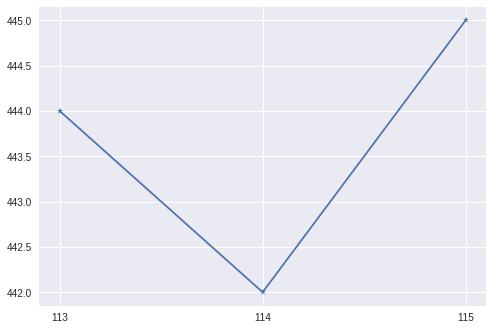

In [63]:
plt.plot(["113", "114", "115"], [h113.count()[0],h114.count()[0],h115.count()[0]], "-*")

My first thought was that it should remain constant. But looking into it, I can see that the dataset contains everyone who served any amount of time during those congresses. So substitutes are counted as well, which explains the difference.

### 4.2) How many members appear in all the three congresses? How many in two? How many in one? Plot your results using a histogram.


In [ ]:
set3 = set( h113.WikiPageName.values.tolist() )
set4 = set( h114.WikiPageName.values.tolist() )
set5 = set( h115.WikiPageName.values.tolist() )

# in all 3
a3 = set3.intersection(set4, set5)

# only in 3
a = set3 - set3.intersection(set4) - set3.intersection(set5)
# only in 4
b = set4 - set4.intersection(set3) - set4.intersection(set5)
# only in 5
c = set3 - set5.intersection(set3) - set5.intersection(set4)


# only in 3 and 4
# all those in both 3 and 4 - those both in 3 and 4 that are also in 5
a2 = set3.intersection(set4) - set5.intersection( set3.intersection(set4) )
# only in 3 and 5
b2 = set3.intersection(set5) - set4.intersection( set3.intersection(set5) )
# only in 4 and 5
c2 = set4.intersection(set5) - set3.intersection( set4.intersection(set5) )

len_1 = len(a) + len(b) + len(c)
len_2 = len(a2) + len(b2) + len(c2)
len_3 = len(a3)


<Container object of 3 artists>

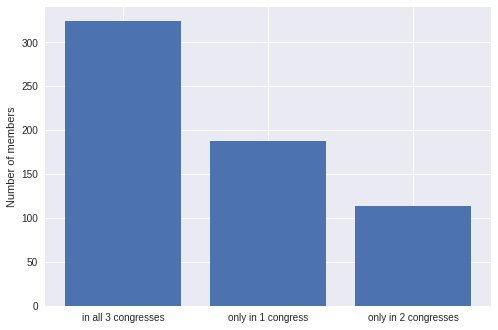

In [65]:
plt.ylabel("Number of members")
plt.bar(["only in 1 congress", "only in 2 congresses", "in all 3 congresses"], [len_1, len_2, len_3] )

### 4.3) Which states are more represented in the house of representatives? Which are less? Plot a histogram showing the number of members per state.


In [ ]:
state3 = h113.State.value_counts()
state4 = h114.State.value_counts()
state5 = h115.State.value_counts()

In [67]:
# The 5 MOST represented states in the 113th congress
state3.head(5)

California    53
Texas         36
Florida       29
New York      27
Illinois      18
Name: State, dtype: int64

In [68]:
# The 7 LEAST represented states in the 113th congress (all have just one)
state3.tail(7)

Wyoming         1
Alaska          1
Montana         1
South Dakota    1
Vermont         1
North Dakota    1
Delaware        1
Name: State, dtype: int64

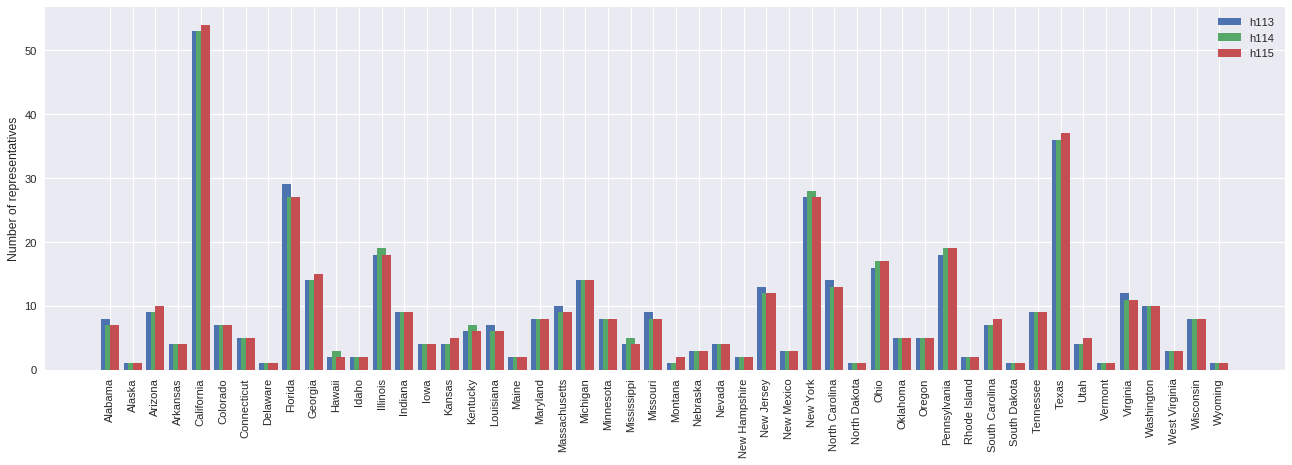

In [69]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')

plt.xticks(rotation='vertical')
plt.bar(state3.keys(), state3.values, align="edge", width=-0.4, label="h113")
plt.bar(state4.keys(), state4.values, align="center", width=0.4, label="h114")
plt.bar(state5.keys(), state5.values, align="edge", width=0.4, label="h115")
plt.ylabel("Number of representatives")
plt.legend()
plt.show()

### 4.4) How has the party composition of the house of representative changed over time? Plot your results.

In [ ]:
party, counts3 = np.unique( h113.Party, return_counts=True )
party, counts4 = np.unique( h114.Party, return_counts=True )
party, counts5 = np.unique( h115.Party, return_counts=True )

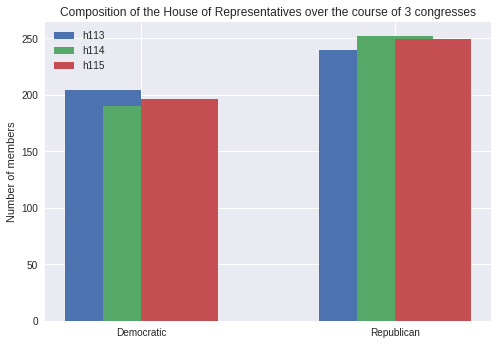

In [71]:
plt.bar(party, counts3, label="h113", align="edge", width=-0.3)
plt.bar(party, counts4, label="h114", align="center", width=0.3)
plt.bar(party, counts5, label="h115", align="edge", width=0.3)
plt.legend()
plt.ylabel("Number of members")
plt.title("Composition of the House of Representatives over the course of 3 congresses")
plt.show()

## 5. Basic stats for the network
Create simple network statistics for the 113th house of representatives.

### 5.0) Get data and create graph

In [72]:
import io
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# for each wiki page name
# open its file, loads it texts
# use regex to find all links
# for every other wiki page name, try to find it in the list of links

graph_dict = {}


folder_path = '/content/gdrive/My Drive/DTU/data/'
link_pattern = r'\[\[.*?\]\]'
for i, page_name in enumerate( h113.WikiPageName[:] ):
  print "%s %s" % (i, page_name)
  file_name =  page_name + '.txt'
  with io.open(folder_path + file_name, "r", encoding="utf8") as f:
    wiki_text = f.read()
  # find links in text
  links = re.findall(link_pattern, wiki_text)
  # for every page name (execpt itself), look for it in links
  graph_dict[page_name] = set()
  for p_n in h113.WikiPageName:
    if p_n is not page_name:
      for l in links:
        p_n_no_underscore = p_n.replace("_", " ")
        if l.find(p_n_no_underscore.decode("utf-8")) > -1: # name found in link
          graph_dict[page_name].add(p_n)

In [ ]:
g = nx.DiGraph()

# add all nodes with attributes
for i in range( len(h113.WikiPageName) ):
  name = h113.WikiPageName[i]
  party = h113.Party[i]
  state = h113.State[i]
  g.add_node(name, party=party, state=state)

# add all edges
for name in graph_dict.keys():
  out_links = graph_dict[name]
  for out_name in out_links:
    g.add_edge(name, out_name)

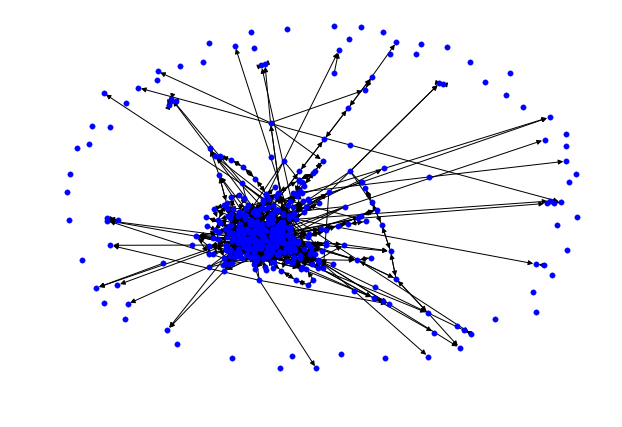

In [76]:
nx.draw(g, node_size=30, node_color="blue")

### 5.1) What is the number of nodes in the network? And the number of links?

In [94]:
print "# nodes: %s" % g.number_of_nodes()
print "# edges: %s" % g.number_of_edges()

# nodes: 444
# edges: 1058


### 5.2) Plot the in and out-degree distributions.

In [ ]:
in_degrees = []
out_degrees = []
member_order = []

for n in g.nodes():
  member_order.append(n)
  in_degrees.append( g.in_degree(n) )
  out_degrees.append( g.out_degree(n) )
  
# in_deg_sort = sorted(in_degrees)
# out_deg_sort = sorted(out_degrees)

# sort members with the in- and out-degree sorting (useful for finding the most connected members)
in_deg_sort, member_in_sort = (list(t) for t in zip(*sorted(zip(in_degrees, member_order))))
out_deg_sort, member_out_sort = (list(t) for t in zip(*sorted(zip(out_degrees, member_order))))


In [97]:
# max for in- and out-degree distributions
print "in-degree max: %s" % max(in_degrees)
in_count = np.bincount( in_degrees )

print "out-degree max: %s" % max(out_degrees)
out_count = np.bincount(out_degrees)

in-degree max: 52
out-degree max: 20


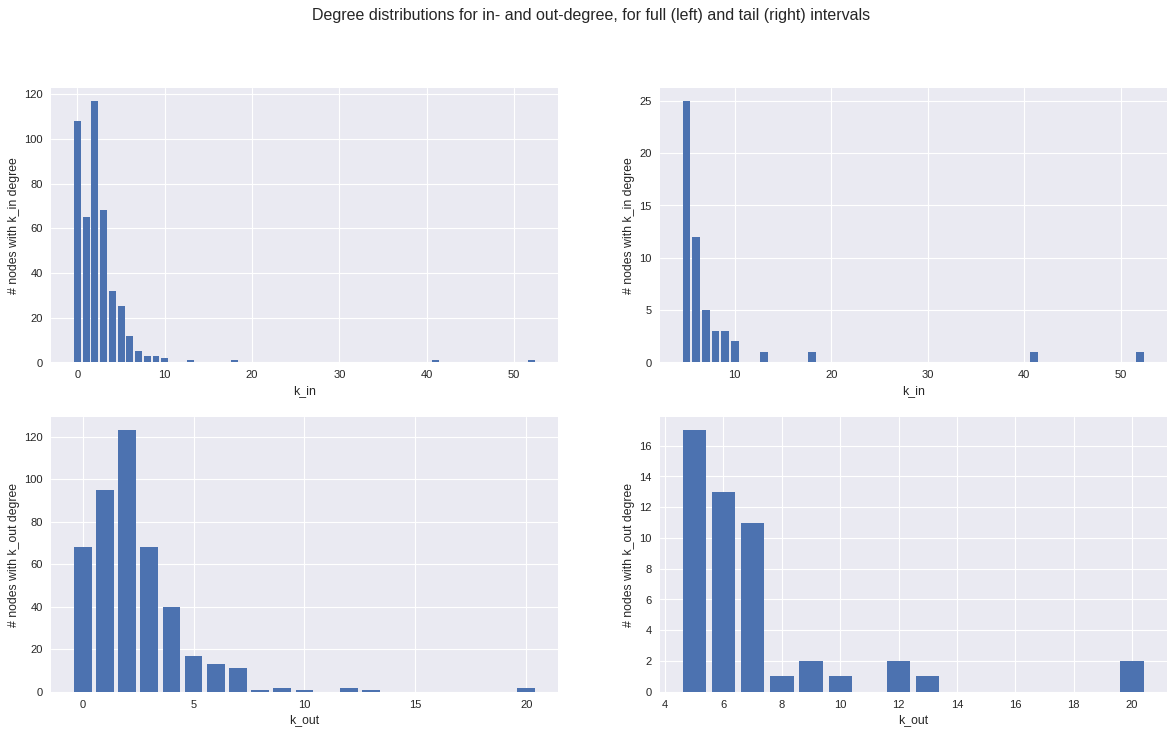

In [98]:
# plot degree distributions
from matplotlib.pyplot import figure
fig = figure(num=None, figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
fig.suptitle("Degree distributions for in- and out-degree, for full (left) and tail (right) intervals")

plt.subplot(2,2,1)
plt.ylabel("# nodes with k_in degree")
plt.xlabel("k_in")
plt.bar(range(len(in_count)), in_count)

plt.subplot(2,2,2)
plt.ylabel("# nodes with k_in degree")
plt.xlabel("k_in")
offset_in = 5
plt.bar(map(lambda x: x+offset_in, range(len(in_count[offset_in:]))), in_count[offset_in:])


plt.subplot(2,2,3)
plt.ylabel("# nodes with k_out degree")
plt.xlabel("k_out")
plt.bar( range(len(out_count)), out_count )

plt.subplot(2,2,4)
plt.ylabel("# nodes with k_out degree")
plt.xlabel("k_out")
offset_out = 5
plt.bar(map(lambda x: x+offset_out, range(len(out_count[offset_out:]))), out_count[offset_out:])

plt.show()

### 5.3) Who is the most connected representative?

In [99]:
max_k = 0
most_connected_idx = None
for i, (k_in,k_out) in enumerate( zip(in_degrees, out_degrees) ):
  k = k_in + k_out
  if k > max_k:
    max_k = k
    most_connected_idx = i
    
print "The most connected representative: %s" % member_order[most_connected_idx]
print "In degree: %s" % in_degrees[most_connected_idx]
print "Out degree: %s" % out_degrees[most_connected_idx]

The most connected representative: Nancy_Pelosi
In degree: 52
Out degree: 7


Peculiarly, only one of the top 10 in-degree politicians appear in the top 10 out-degree list

In [100]:
top10_in = member_in_sort[-10:]
top10_out = member_out_sort[-10:]
set(top10_in).intersection( set(top10_out) )

{'Jim_McGovern_(American_politician)'}